# Libraries

In [3]:
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [4]:
%%capture
!pip install imbalanced-learn
!pip install keras-tuner
import os
import csv
import warnings
import IPython
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics as skm
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from keras import layers, models, utils
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing import image
from scipy.stats import uniform, randint
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import librosa.display
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch

# Extracting Dataframe

In [6]:
# Define o caminho raiz onde o conjunto de dados está armazenado

# Inicializa listas vazias para armazenar caminhos de arquivos e seus respectivos estados de humor
paths = []
moods = []

# Itera sobre as pastas de humor no caminho raiz
for mood in os.listdir(rootPath):
    # Itera sobre os arquivos dentro de cada pasta de humor
    for file in os.listdir(rootPath + "/" + mood):
        # Constrói o caminho completo do arquivo e o adiciona à lista de caminhos
        paths.append(rootPath + "/" + mood + "/" + file)
        # Adiciona o humor atual à lista de estados de humor
        moods.append(mood)

# Cria um DataFrame do Pandas com as colunas "filePath" e "mood"
data = pd.DataFrame(columns=["filePath", "mood"])

# Atribui as listas de caminhos de arquivo e estados de humor às respectivas colunas do DataFrame
data["filePath"] = paths
data["mood"] = moods

# Model

### Helper Function

In [7]:
# Define funções para criar espectrogramas e carregar imagens
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)
    fig.savefig(image_file)
    plt.close(fig)

In [8]:
def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    for file in os.listdir(input_path):
        if file.endswith('.wav'):
            input_file = os.path.join(input_path, file)
            output_file = os.path.join(output_path, file.replace('.wav', '.png'))
            create_spectrogram(input_file, output_file)

In [9]:
# Função para carregar imagens a partir de um diretório
def load_images_from_path(path, label):
    images_CNN_Aut = []
    labels_CNN_Aut = []
    for file in os.listdir(path):
        if file.endswith('.png'):
            img = image.load_img(os.path.join(path, file), target_size=(224, 224))
            img_array = image.img_to_array(img)
            images_CNN_Aut.append(img_array)
            labels_CNN_Aut.append(label)
    return images_CNN_Aut, labels_CNN_Aut

In [10]:
# Função para criar o modelo com hiperparâmetros variáveis
def build_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(units=hp.Int('units', min_value=128, max_value=1024, step=128), activation='relu')(x)
    x = Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    output = Dense(len(emotions), activation='softmax')(x)

    model_CNN_Aut = Model(inputs=base_model.input, outputs=output)
    model_CNN_Aut.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model_CNN_Aut

### Spectrogramas

In [ ]:
# Gerar espectrogramas para cada categoria de emoção
emotions = ["aggressive", "dramatic", "happy", "romantic", "sad"]
for emotion in emotions:
    create_pngs_from_wavs(f"{rootPath}/{emotion}", f"{dataset_spectrograma}/{emotion}")

In [12]:
# Carregar as imagens e os rótulos
x_CNN_Aut = []
y_CNN_Aut = []

for emotion in emotions:
    images, labels = load_images_from_path( f"{dataset_spectrograma}/{emotion}", emotion)
    x_CNN_Aut.extend(images)
    y_CNN_Aut.extend(labels)

### Encoding labels

In [13]:
# Converter listas para arrays numpy
x_CNN_Aut = np.array(x_CNN_Aut)
y_CNN_Aut = np.array(y_CNN_Aut)

# Codificar rótulos
label_encoder = LabelEncoder()
y_CNN_Aut_encoded = label_encoder.fit_transform(y_CNN_Aut)

### Splitting the dataset 

In [14]:
# Divisão do dataset em treino e teste
x_train_CNN_Aut, x_test_CNN_Aut, y_train_CNN_Aut, y_test_CNN_Aut = train_test_split(x_CNN_Aut, y_CNN_Aut_encoded, stratify=y_CNN_Aut_encoded, test_size=0.2, random_state=0)

# Normalização
x_train_norm_CNN_Aut = x_train_CNN_Aut / 255.0
x_test_norm_CNN_Aut = x_test_CNN_Aut / 255.0

# Codificação categórica
y_train_encoded_CNN_Aut = to_categorical(y_train_CNN_Aut)
y_test_encoded_CNN_Aut = to_categorical(y_test_CNN_Aut)

### Training the model

In [16]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Configurar a busca de hiperparâmetros
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='hyperparam_tuning',
    project_name='emotion_prediction',
    overwrite=False  
)

# Executar a busca de hiperparâmetros
tuner.search(x_train_norm_CNN_Aut, y_train_encoded_CNN_Aut, epochs=30, validation_data=(x_test_norm_CNN_Aut, y_test_encoded_CNN_Aut))

# Resumo dos melhores hiperparâmetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Melhores hiperparâmetros: {best_hps.values}")

# Treinar o modelo com os melhores hiperparâmetros
model_CNN_Aut = tuner.hypermodel.build(best_hps)
history = model_CNN_Aut.fit(x_train_norm_CNN_Aut, y_train_encoded_CNN_Aut, epochs=30, validation_data=(x_test_norm_CNN_Aut, y_test_encoded_CNN_Aut))

Reloading Tuner from hyperparam_tuning/emotion_prediction/tuner0.json
Melhores hiperparâmetros: {'units': 512, 'dropout': 0.30000000000000004, 'learning_rate': 0.0003209523930194174}
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.2562 - loss: 3.2845 - val_accuracy: 0.4308 - val_loss: 2.3692
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4295 - loss: 2.2851 - val_accuracy: 0.3077 - val_loss: 1.6567
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4134 - loss: 1.4878 - val_accuracy: 0.4154 - val_loss: 1.3234
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5156 - loss: 1.2620 - val_accuracy: 0.4000 - val_loss: 1.3595
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5448 - loss: 1.1010 - val_accuracy: 0.4462 - val_loss: 1.2835
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6203 - loss: 0.9925 - val_accuracy: 0.4615 - val_loss: 1.2926
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6210 - loss

# Acuracy History

[]

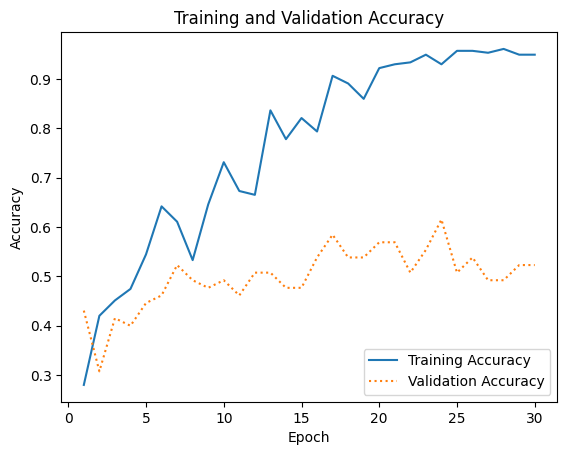

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

# Model Results

In [18]:
class ModelResults:
    def __init__(self, model, class_labels):
        self.model = model
        self.class_labels = class_labels

    def predict(self, x_test):
        y_predicted = self.model.predict(x_test)
        return y_predicted

    def plot_confusion_matrix(self, y_true, y_pred):
        mat = confusion_matrix(y_true, y_pred)
        sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
                    xticklabels=self.class_labels,
                    yticklabels=self.class_labels)
        plt.xlabel('Predicted label')
        plt.ylabel('Actual label')
        plt.show()

    def classification_report(self, y_true, y_pred):
        report = classification_report(y_true, y_pred, target_names=self.class_labels, digits=3)
        print(report)

    def evaluate(self, x_test, y_true):
        y_predicted = self.predict(x_test)
        y_pred_classes = np.argmax(y_predicted, axis=1)
        y_true_classes = np.argmax(y_true, axis=1)
        self.plot_confusion_matrix(y_true_classes, y_pred_classes)
        self.classification_report(y_true_classes, y_pred_classes)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 839ms/step


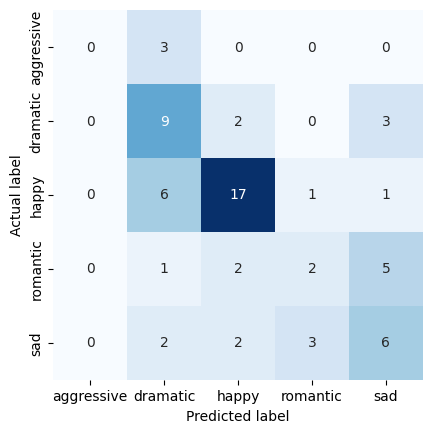

              precision    recall  f1-score   support

  aggressive      0.000     0.000     0.000         3
    dramatic      0.429     0.643     0.514        14
       happy      0.739     0.680     0.708        25
    romantic      0.333     0.200     0.250        10
         sad      0.400     0.462     0.429        13

    accuracy                          0.523        65
   macro avg      0.380     0.397     0.380        65
weighted avg      0.508     0.523     0.507        65



In [19]:
class_labels = ['aggressive', 'dramatic', 'happy', 'romantic', 'sad']
model_results = ModelResults(model_CNN_Aut, class_labels)

# Avaliar o modelo
model_results.evaluate(x_test_norm_CNN_Aut, y_test_encoded_CNN_Aut)

### Prediction

### Dataset 3

In [20]:
emotions_actual = {}
with open(csv_predicao, "r", encoding="utf-8") as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        if len(row) >= 2:
            audio_id, emotion = row[:2]  # Lê apenas as duas primeiras colunas
            emotions_actual[audio_id.zfill(3) + '.wav'] = emotion  # Correlaciona o número com o nome do arquivo
        else:
            print(f"Entrada inválida: {row}")
            
# Exibir o número total de entradas carregadas
print(f"Total de entradas carregadas: {len(emotions_actual)}")

# Percorrer os áudios no novo conjunto de dados e armazenar as predições
predictions = {}
none_audio_files = []  # Lista para armazenar os arquivos associados a 'None'
class_labels = ['agressive', 'dramatic', 'happy', 'romantic', 'sad']

for audio_file in os.listdir(dataset_path):
    if audio_file.endswith('.wav'):
        audio_path = os.path.join(dataset_path, audio_file)

        # Criação do espectrograma
        spectrogram_path = f"{dataset_spectrograma_validation_data3}/{audio_file.replace('.wav', '.png')}"
        if not os.path.exists(spectrogram_path):
            create_spectrogram(audio_path, spectrogram_path)

        # Carregamento da imagem
        img = image.load_img(spectrogram_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Previsão com o modelo CNN
        prediction = model_CNN_Aut.predict(img_array)
        predicted_emotion = class_labels[np.argmax(prediction)]
        predictions[audio_file] = predicted_emotion

        # Verifica se a emoção real está presente no CSV
        actual_emotion = emotions_actual.get(audio_file, None)
        if actual_emotion is None:  # Se a emoção real não estiver presente
            none_audio_files.append(audio_file)

# Comparar as predições com as emoções reais e imprimir
correct_predictions = 0
total_predictions = len(predictions)
for audio_file, predicted_emotion in predictions.items():
    actual_emotion = emotions_actual.get(audio_file, None)
    if actual_emotion is not None:  # Se a emoção real estiver presente
        if actual_emotion == predicted_emotion:
            correct_predictions += 1

# Imprime a acurácia do modelo
accuracy = correct_predictions / total_predictions
print(f'Acurácia do modelo: {accuracy * 100:.2f}%')

Total de entradas carregadas: 371
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━

In [21]:
# Imprime informações sobre os 'None'
print(f'Número de músicas com emoção real como None: {len(none_audio_files)}')
print(f'Músicas com emoção real como None: {none_audio_files}')

Número de músicas com emoção real como None: 0
Músicas com emoção real como None: []


### Dataset 1

In [22]:
emotions_actual = {}
with open(csv_predicao_2, "r", encoding="utf-8") as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        if len(row) >= 2:
            audio_id, emotion = row[:2]  # Lê apenas as duas primeiras colunas
            emotions_actual[audio_id.zfill(3) + '.wav'] = emotion  # Correlaciona o número com o nome do arquivo
        else:
            print(f"Entrada inválida: {row}")
            
# Exibir o número total de entradas carregadas
print(f"Total de entradas carregadas: {len(emotions_actual)}")

# Percorrer os áudios no novo conjunto de dados e armazenar as predições
predictions = {}
none_audio_files = []  # Lista para armazenar os arquivos associados a 'None'
class_labels = ['agressive', 'dramatic', 'happy', 'romantic', 'sad']

for audio_file in os.listdir(dataset_path_2):
    if audio_file.endswith('.wav'):
        audio_path = os.path.join(dataset_path_2, audio_file)

        # Criação do espectrograma
        spectrogram_path = f"{dataset_spectrograma_validation_data1}/{audio_file.replace('.wav', '.png')}"
        if not os.path.exists(spectrogram_path):
            create_spectrogram(audio_path, spectrogram_path)

        # Carregamento da imagem
        img = image.load_img(spectrogram_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Previsão com o modelo CNN
        prediction = model_CNN_Aut.predict(img_array)
        predicted_emotion = class_labels[np.argmax(prediction)]
        predictions[audio_file] = predicted_emotion

        # Verifica se a emoção real está presente no CSV
        actual_emotion = emotions_actual.get(audio_file, None)
        if actual_emotion is None:  # Se a emoção real não estiver presente
            none_audio_files.append(audio_file)

# Comparar as predições com as emoções reais e imprimir
correct_predictions = 0
total_predictions = len(predictions)
for audio_file, predicted_emotion in predictions.items():
    actual_emotion = emotions_actual.get(audio_file, None)
    if actual_emotion is not None:  # Se a emoção real estiver presente
        if actual_emotion == predicted_emotion:
            correct_predictions += 1

# Imprime a acurácia do modelo
accuracy = correct_predictions / total_predictions
print(f'Acurácia do modelo: {accuracy * 100:.2f}%')

Total de entradas carregadas: 2500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━

In [23]:
# Imprime informações sobre os 'None'
print(f'Número de músicas com emoção real como None: {len(none_audio_files)}')
print(f'Músicas com emoção real como None: {none_audio_files}')

Número de músicas com emoção real como None: 0
Músicas com emoção real como None: []
